In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import Modules
import ast
from collections import Counter
import numpy as np
from pandas_profiling import ProfileReport
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn.datasets
from scipy import spatial
from scipy.sparse import csr_matrix
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.patches as patches
import mplcyberpunk
import seaborn as sns
from typing import List, Dict, Callable

%matplotlib inline
# plt.style.use('ggplot')
plt.style.use("cyberpunk")

In [3]:
from src.helpers import *

In [55]:
# Import Data
movies = pd.read_csv('cleaned_data/movies.csv')
users = pd.read_csv('cleaned_data/users.csv')
ratings = pd.read_csv('cleaned_data/ratings.csv')
nans = pd.read_csv('cleaned_data/nan_users.csv', )
ratings = ratings.rename(columns={'movie':'movie_id'})

In [5]:
users = users.drop(columns=['zipclean', 'occ'])
users

,user_id,gender,age,zipcode,occ_name
0,1,F,1,48067,K-12 student
1,2,M,56,70072,self-employed
2,3,M,25,55117,scientist
3,4,M,45,02460,executive/managerial
4,5,M,25,55455,writer
...,...,...,...,...,...
6035,6036,F,25,32603,scientist
6036,6037,F,45,76006,academic/educator
6037,6038,F,56,14706,academic/educator
6038,6039,F,45,01060,other


In [6]:
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  800000  ratings of  3883  movies.


In [7]:
ratings

,user,movie_id,rating
0,6040,858,4
1,6040,593,5
2,6040,2384,4
3,6040,1961,4
4,6040,2019,5
...,...,...,...
799995,1875,2940,5
799996,1875,589,4
799997,1875,110,4
799998,1875,2791,3


In [8]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movie_id', 'movie_title']], on='movie_id' )
user_movie_ratings = pd.pivot_table(ratings_title, index='user', columns= 'movie_title', values='rating')

print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (5399, 3662) 

Subset example:


movie_title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957)
user,,,,,,,,,,
636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0
638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

print('dataset dimensions: ', most_rated_movies_users_selection.shape)
most_rated_movies_users_selection.head()

dataset dimensions:  (18, 30)


movie_title,American Beauty (1999),Star Wars: Episode V - The Empire Strikes Back (1980),Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode VI - Return of the Jedi (1983),Terminator 2: Judgment Day (1991),Saving Private Ryan (1998),Jurassic Park (1993),Back to the Future (1985),"Matrix, The (1999)",Men in Black (1997),...,Star Wars: Episode I - The Phantom Menace (1999),Being John Malkovich (1999),Groundhog Day (1993),"Godfather, The (1972)","Shawshank Redemption, The (1994)",Ghostbusters (1984),Forrest Gump (1994),Pulp Fiction (1994),"Terminator, The (1984)",Toy Story (1995)
3274,5.0,5.0,5.0,4.0,3.0,5.0,4.0,4.0,5.0,3.0,...,3.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0
648,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,...,3.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
751,5.0,5.0,5.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,...,4.0,3.0,5.0,5.0,5.0,5.0,5.0,1.0,5.0,5.0
4458,4.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,...,1.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0
2623,5.0,5.0,5.0,5.0,5.0,5.0,4.0,3.0,5.0,5.0,...,3.0,3.0,3.0,5.0,5.0,4.0,4.0,5.0,4.0,4.0


In [10]:
user_movie_ratings =  pd.pivot_table(ratings_title, index='user', columns= 'movie_title', values='rating')
most_rated_movies = get_most_rated_movies(user_movie_ratings, user_movie_ratings.shape[0])

In [11]:
sparse_ratings = csr_matrix(most_rated_movies.apply(lambda x: pd.arrays.SparseArray(x)).sparse.to_coo())

In [12]:
# Predict 20 clusters
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)

cluster # 1
# of users in cluster: 272. # of users in plot: 70


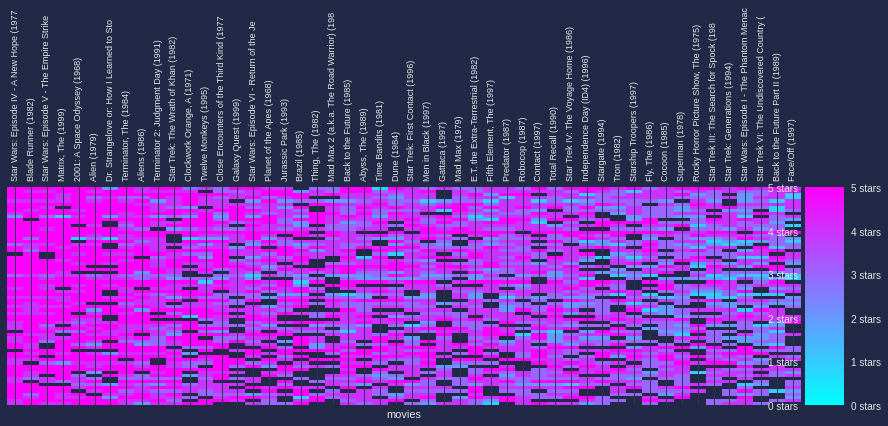

cluster # 12
# of users in cluster: 108. # of users in plot: 70


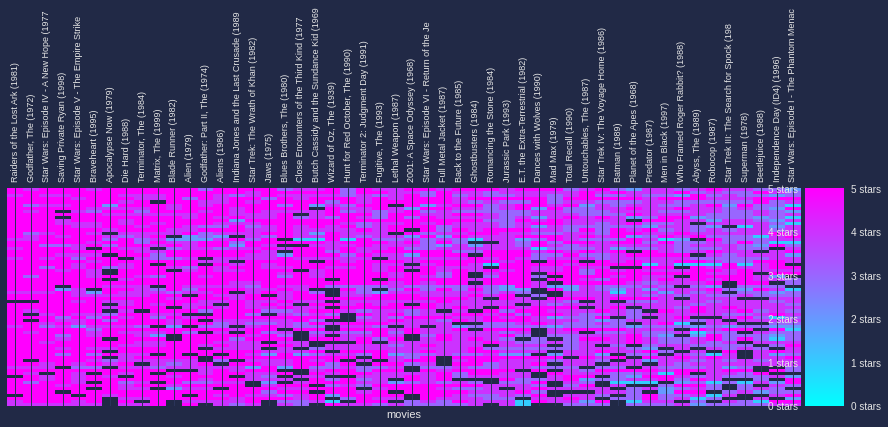

cluster # 19
# of users in cluster: 264. # of users in plot: 70


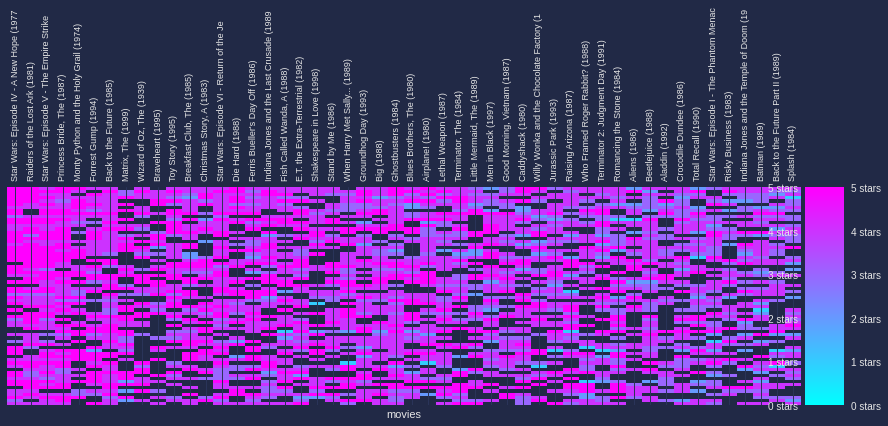

cluster # 17
# of users in cluster: 207. # of users in plot: 70


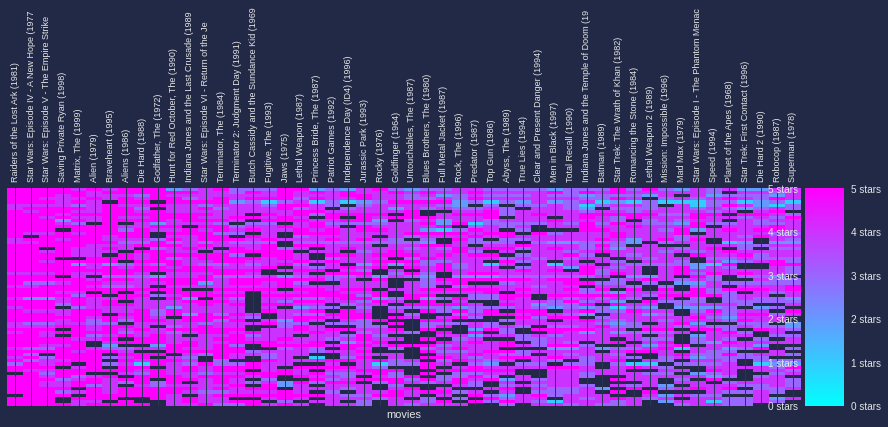

cluster # 11
# of users in cluster: 2082. # of users in plot: 70


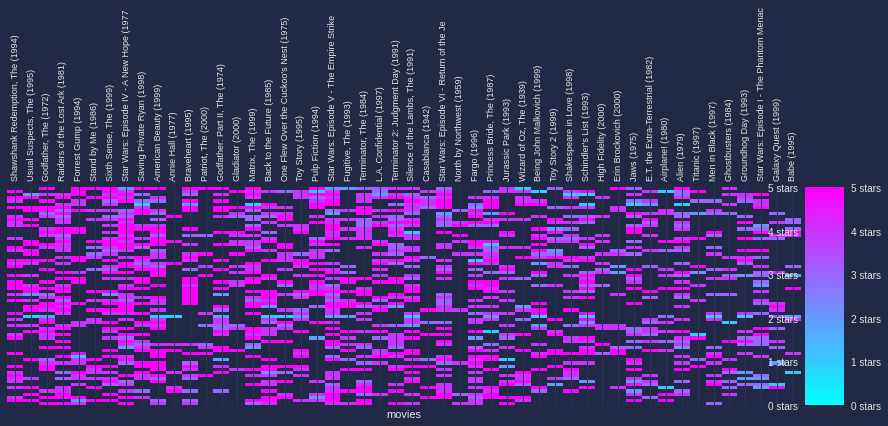

cluster # 3
# of users in cluster: 432. # of users in plot: 70


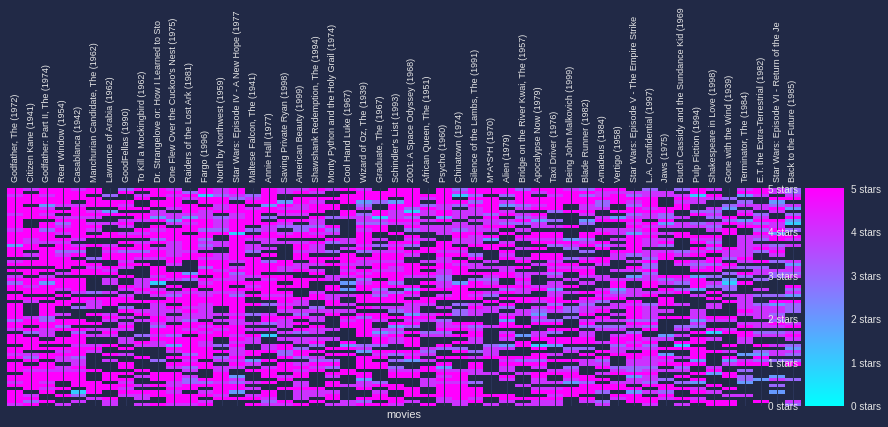

cluster # 0
# of users in cluster: 337. # of users in plot: 70


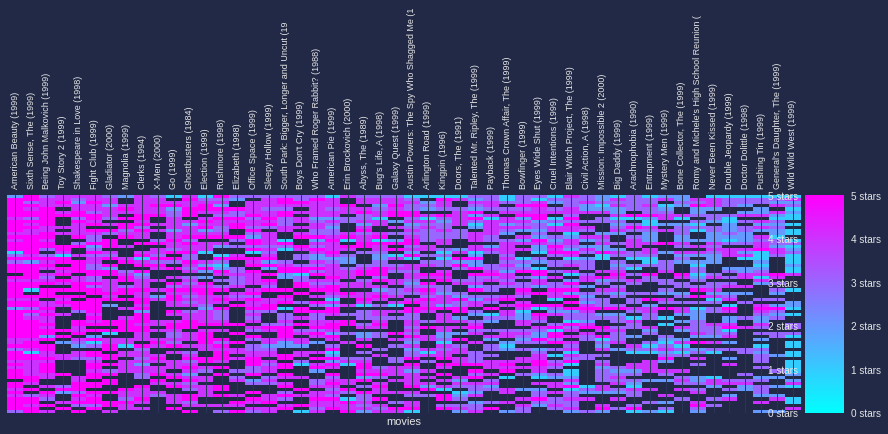

cluster # 9
# of users in cluster: 272. # of users in plot: 70


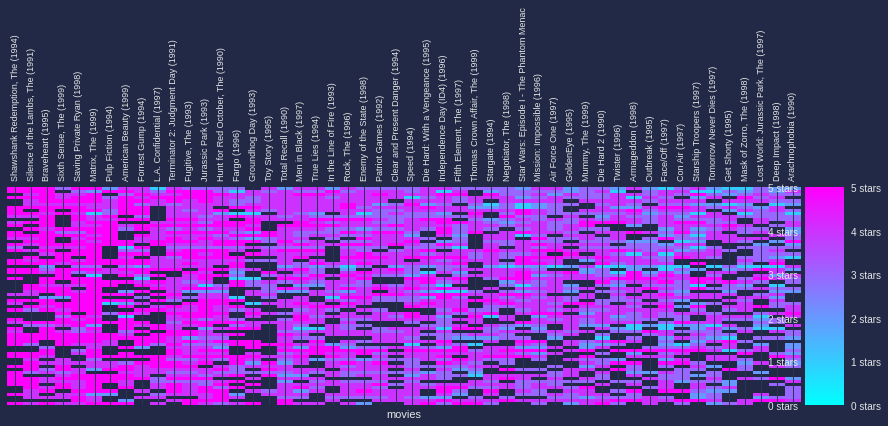

cluster # 15
# of users in cluster: 363. # of users in plot: 70


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0, flags=flags)


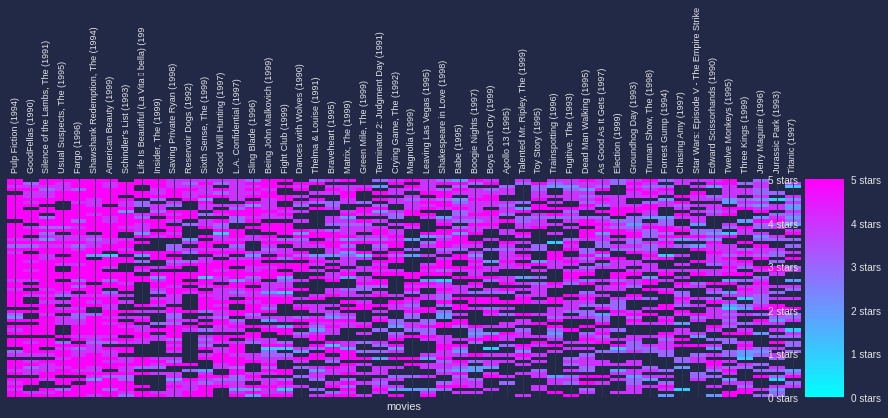

cluster # 4
# of users in cluster: 182. # of users in plot: 70


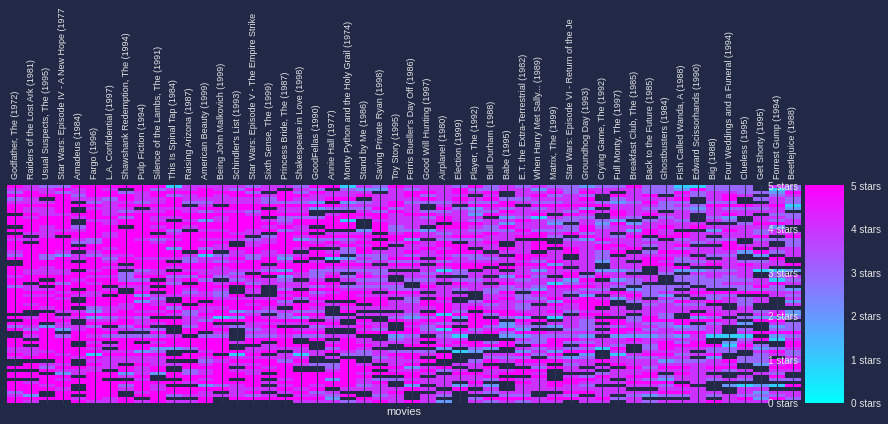

cluster # 10
# of users in cluster: 145. # of users in plot: 70


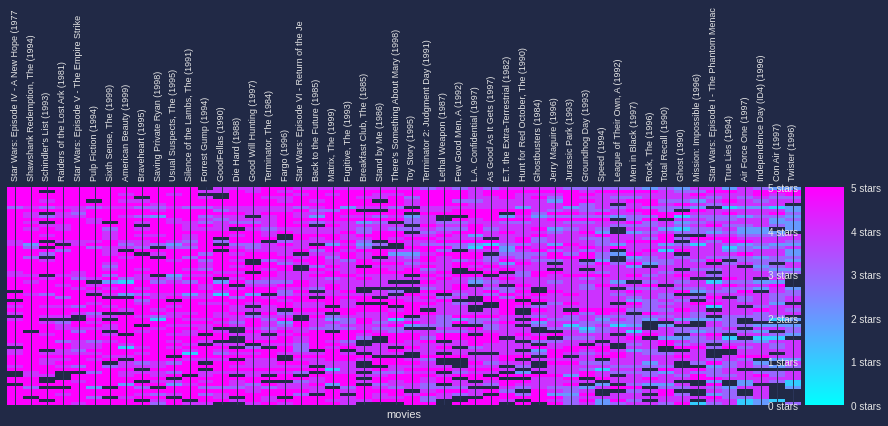

cluster # 14
# of users in cluster: 116. # of users in plot: 70


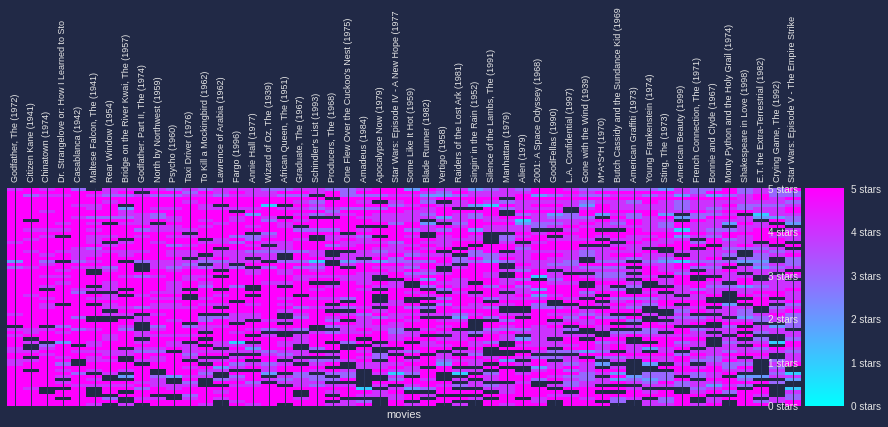

cluster # 16
# of users in cluster: 60. # of users in plot: 60


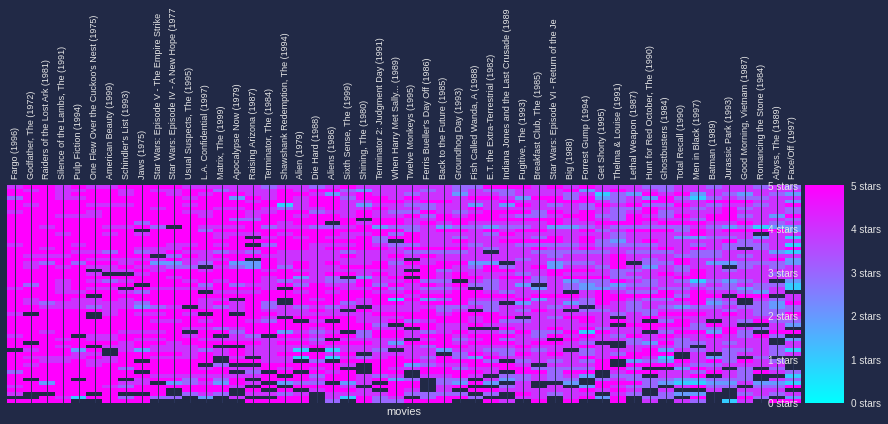

cluster # 2
# of users in cluster: 149. # of users in plot: 70


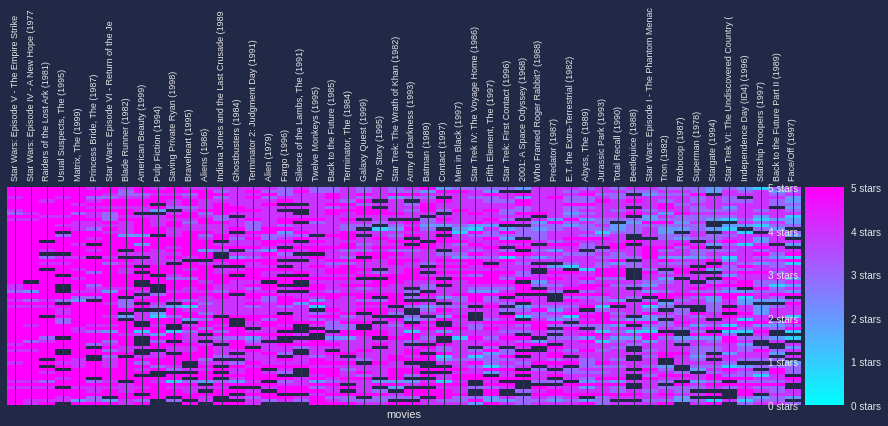

cluster # 8
# of users in cluster: 317. # of users in plot: 70


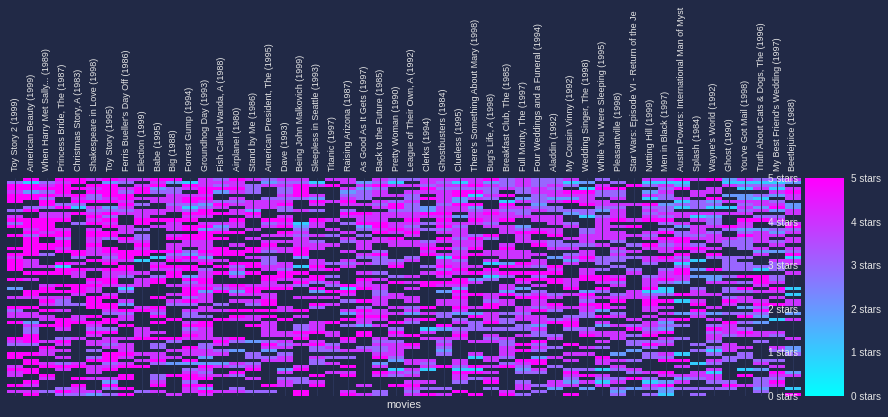

cluster # 5
# of users in cluster: 49. # of users in plot: 49


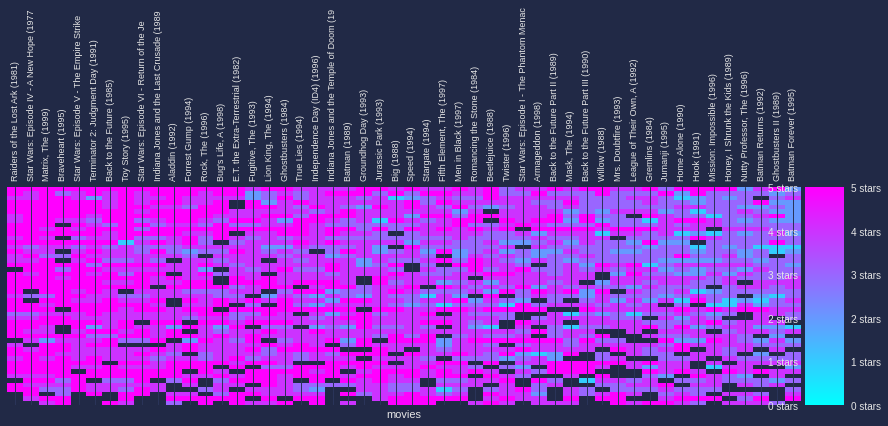

cluster # 7
# of users in cluster: 16. # of users in plot: 16


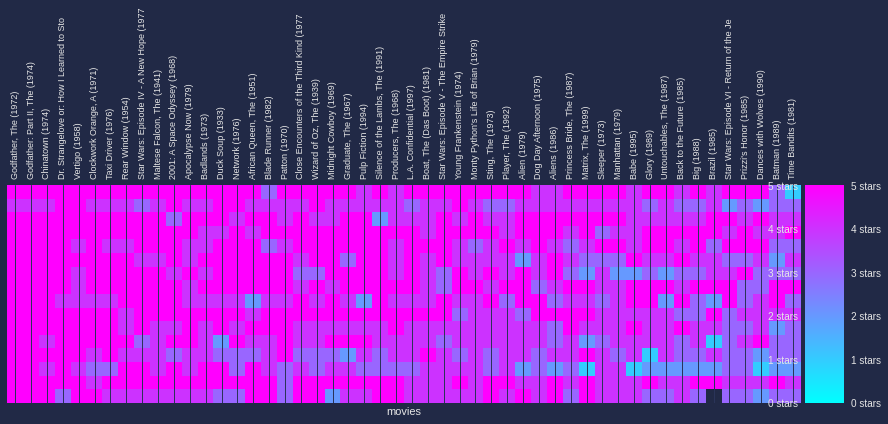

cluster # 6
# of users in cluster: 19. # of users in plot: 19


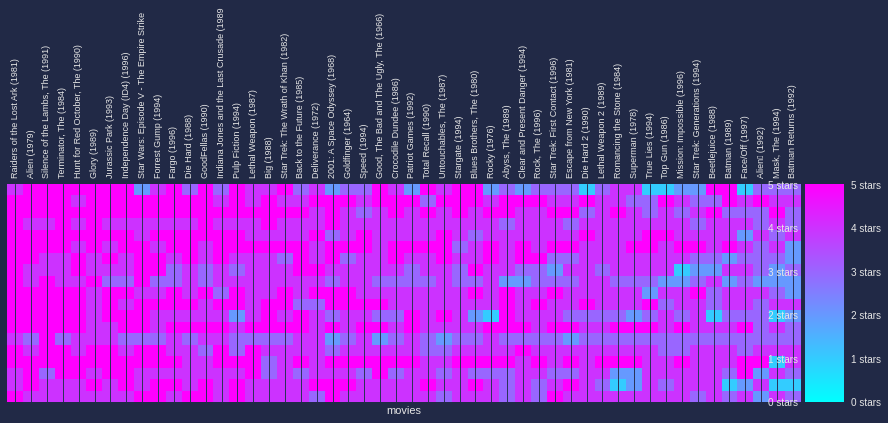

In [13]:
# Plot Heatmap
max_users = 70
max_movies = 50

clustered = pd.concat([most_rated_movies.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
draw_movie_clusters(clustered, max_users, max_movies)

In [14]:
groups = clustered.groupby('group')

In [15]:
nans = nans.drop(columns = ['Unnamed: 0', 'prediction'])

In [59]:
def find_final_rating(user:int, movie:int) -> np.float:
    group_no = int(clustered.iloc[user]['group'])
    cluster = clustered[clustered.group == group_no].drop(['index', 'group'], axis=1)
    # Get Movie Name
    mov = movies[movies['movie_id'] == movie]['movie_title'].tolist()[0]
    return (cluster[mov].mean())

In [60]:
find_final_rating(1875, 3793)

3.821256038647343

In [18]:
# fake_test['predicitons'] = predictions

In [20]:
# fake_test

In [80]:
# Load Results to Fill NA Predictions
data = pd.read_csv('cleaned_data/results.csv')
data

,Unnamed: 0,user,movie,prediction,rating
0,0,53,148,NaN,3.590479
1,1,4169,148,3.049647,3.049647
2,2,5333,148,2.599816,2.599816
3,3,4387,148,2.161370,2.161370
4,4,840,148,2.586383,2.586383
...,...,...,...,...,...
200204,200204,3371,3910,3.716271,3.716271
200205,200205,1851,3910,3.139582,3.139582
200206,200206,5198,3910,3.575140,3.575140
200207,200207,1584,3910,3.147175,3.147175


In [46]:
res = data.drop(columns=['Unnamed: 0', 'rating']).rename(columns={'prediction':'rating'})
res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200209 entries, 0 to 200208
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   user    200209 non-null  int64  
 1   movie   200209 non-null  int64  
 2   rating  104439 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 4.6 MB


In [85]:
users_list, movies_list, ratings_list = res['user'].tolist(), res['movie'].tolist(), res['rating'].tolist() 
alt_rating_list = data['rating'].tolist()

In [ ]:
rating_res = []
for user, movie, rating, alt_rating in zip(users_list, movies_list, ratings_list, alt_rating_list):
    if pd.isnull(rating):
        try:
            res = find_final_rating(user, movie)
            if res:
                rating_res.append(res)
            else:
                rating_res.append(alt_rating)
        except:
            rating_res.append(alt_rating)
    else:
        rating_res.append(rating)

In [68]:
# find_final_rating(53, 148)

In [ ]:
# x = int(clustered.iloc[53]['group'])

In [ ]:
test_k_vals = range(2, len(X)+1, 5)

# Calculate error values for all k values we're interested in
err_on_k = [helper.clustering_errors(k, X) for k in test_k_vals]

list(zip(test_k_vals, err_on_k))